# So sánh Thuật toán Optimization trên bài toán Ackley Function

## Comparison: Hill Climbing (Traditional) vs Cuckoo Search

### Ackley Function
- **Type**: Continuous optimization benchmark
- **Global minimum**: f(0, 0, ..., 0) = 0
- **Domain**: typically [-5, 5]^d
- **Characteristics**: Nhiều local minima, test khả năng escape local optima

## Các metrics đánh giá:
1. **Convergence Speed** (Tốc độ hội tụ): Tốc độ đạt được global minimum
2. **Computational Complexity** (Độ phức tạp tính toán): Số evaluations và thời gian
3. **Robustness** (Tính bền vững): Consistency across different dimensions
4. **Scalability** (Khả năng mở rộng): Performance khi tăng dimensions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from typing import List, Tuple, Dict
import sys
import os

# Add parent directory to path
sys.path.insert(0, os.path.abspath(".."))

from src.swarm_algo.cuckoo import CuckooSearch
from src.search_algo.hill_climbing import HillClimbing, Problem
from src.problem.ackley import AckleyFunction

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

## 1. Load Data và Helper Functions

In [2]:
ACKLEY_DATA_FOLDER = "../data/ackley/"
BOUNDS = (-5.0, 5.0)  # Ackley domain


def get_ackley_problem(problem_num: int) -> Tuple[int, np.ndarray, float]:
    """Load Ackley problem using AckleyFunction class"""
    ackley = AckleyFunction(PROBLEM_FOLDER=ACKLEY_DATA_FOLDER, PROBLEM=problem_num)
    return ackley.dimension, ackley.input_vector, ackley.initial_value


def calculate_error_percentage(result_value, optimal_value=0.0):
    """Calculate error percentage from optimal (0 for Ackley)"""
    epsilon = 1e-10
    if optimal_value == 0:
        return abs(result_value) * 100  # Percentage
    return abs(result_value - optimal_value) / (abs(optimal_value) + epsilon) * 100

## 2. Implement Algorithm Wrappers

In [3]:
class AckleySolver:
    """Base solver for Ackley function"""

    def __init__(self, dimension, bounds=(-5.0, 5.0)):
        self.dimension = dimension
        self.bounds = bounds
        self.optimal_value = 0.0  # Global minimum


class AckleyProblemForHC(Problem):
    """Ackley Problem adapter for Hill Climbing"""

    def __init__(self, problem_num: int, step_size=0.1, data_folder="../data/ackley/"):
        self.ackley = AckleyFunction(PROBLEM_FOLDER=data_folder, PROBLEM=problem_num)
        self.dimension = self.ackley.dimension
        self.bounds = (-5.0, 5.0)
        self.step_size = step_size

    def generate_initial_solution(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], self.dimension)

    def evaluate(self, solution):
        return self.ackley.calculate_fitness(solution)

    def get_neighbors(self, solution):
        neighbors = []
        for i in range(self.dimension):
            neighbor_pos = solution.copy()
            neighbor_pos[i] += self.step_size
            if self.bounds[0] <= neighbor_pos[i] <= self.bounds[1]:
                neighbors.append(neighbor_pos)

            neighbor_neg = solution.copy()
            neighbor_neg[i] -= self.step_size
            if self.bounds[0] <= neighbor_neg[i] <= self.bounds[1]:
                neighbors.append(neighbor_neg)
        return neighbors

    def is_valid(self, solution):
        return np.all((solution >= self.bounds[0]) & (solution <= self.bounds[1]))


class AckleyHillClimbing(AckleySolver):
    """Hill Climbing wrapper for Ackley"""

    def __init__(
        self, problem_num: int, bounds=(-5.0, 5.0), data_folder="../data/ackley/"
    ):
        self.ackley = AckleyFunction(PROBLEM_FOLDER=data_folder, PROBLEM=problem_num)
        self.dimension = self.ackley.dimension
        self.bounds = bounds
        self.optimal_value = 0.0
        self.problem_num = problem_num

    def solve(self, max_iters=300, variant="steepest", step_size=0.1):
        start_time = time.time()
        problem = AckleyProblemForHC(self.problem_num, step_size)

        convergence_history = []
        current_solution = problem.generate_initial_solution()
        current_fitness = problem.evaluate(current_solution)
        convergence_history.append(current_fitness)

        best_solution = current_solution.copy()
        best_fitness = current_fitness
        evaluations = 1

        for iteration in range(max_iters):
            neighbors = problem.get_neighbors(current_solution)
            if not neighbors:
                break

            improved = False
            if variant == "steepest":
                best_neighbor = None
                best_neighbor_fitness = current_fitness

                for neighbor in neighbors:
                    neighbor_fitness = problem.evaluate(neighbor)
                    evaluations += 1
                    if neighbor_fitness < best_neighbor_fitness:
                        best_neighbor_fitness = neighbor_fitness
                        best_neighbor = neighbor
                        improved = True

                if improved:
                    current_solution = best_neighbor
                    current_fitness = best_neighbor_fitness

            if current_fitness < best_fitness:
                best_fitness = current_fitness
                best_solution = current_solution.copy()

            convergence_history.append(best_fitness)
            if not improved:
                break

        end_time = time.time()
        return {
            "solution": best_solution,
            "value": best_fitness,
            "time": end_time - start_time,
            "iterations": len(convergence_history),
            "convergence_history": convergence_history,
            "evaluations": evaluations,
        }


class AckleyCuckoo(AckleySolver):
    """Cuckoo Search wrapper for Ackley"""

    def __init__(
        self, problem_num: int, bounds=(-5.0, 5.0), data_folder="../data/ackley/"
    ):
        self.ackley = AckleyFunction(PROBLEM_FOLDER=data_folder, PROBLEM=problem_num)
        self.dimension = self.ackley.dimension
        self.bounds = bounds
        self.optimal_value = 0.0

    def solve(self, n_cuckoos=50, max_generations=300, pa=0.25, beta=1.5):
        """Solve using Cuckoo Search"""
        start_time = time.time()

        # Create Cuckoo Search optimizer
        cuckoo = CuckooSearch(
            ndim=self.dimension, n_cuckoos=n_cuckoos, pa=pa, beta=beta
        )

        # Cuckoo works in [0,1]^d, need to scale
        def scaled_objective(x_normalized):
            x_scaled = x_normalized * (self.bounds[1] - self.bounds[0]) + self.bounds[0]
            return self.ackley.calculate_fitness(x_scaled)

        cuckoo.set_objective_function(scaled_objective)

        best_position_norm, best_value, convergence_history = cuckoo.run(
            max_generations, visualize=False
        )

        # Scale back to original domain
        best_position = (
            best_position_norm * (self.bounds[1] - self.bounds[0]) + self.bounds[0]
        )

        end_time = time.time()

        return {
            "solution": best_position,
            "value": best_value,
            "time": end_time - start_time,
            "iterations": max_generations,
            "convergence_history": convergence_history,
            "evaluations": n_cuckoos * max_generations,
        }

## 3. Benchmark Functions

In [4]:
def run_comparison(problem_numbers, algorithms_config, n_runs=5):
    """Run comparison across multiple problems with multiple runs"""
    results = []

    for prob_num in problem_numbers:
        print(f"\n{'='*70}")
        print(f"Problem {prob_num}")
        print(f"{'='*70}")

        dimension, initial_vector, initial_value = get_ackley_problem(prob_num)

        print(f"Dimension: {dimension}")
        print(f"Initial value: {initial_value:.6f}")
        print(f"Global optimum: 0.0")

        for algo_name, algo_params in algorithms_config.items():
            print(f"\nRunning {algo_name}...")
            run_results = []

            for run in range(n_runs):
                try:
                    if algo_name == "Hill Climbing":
                        solver = AckleyHillClimbing(prob_num)
                        result = solver.solve(**algo_params)
                    elif algo_name == "Cuckoo Search":
                        solver = AckleyCuckoo(prob_num)
                        result = solver.solve(**algo_params)

                    run_results.append(result)
                except Exception as e:
                    print(f"  Run {run+1} Error: {e}")

            if run_results:
                values = [r["value"] for r in run_results]
                times = [r["time"] for r in run_results]
                iterations = [r["iterations"] for r in run_results]
                evaluations = [r["evaluations"] for r in run_results]

                best_run = run_results[np.argmin(values)]

                result_dict = {
                    "Problem": prob_num,
                    "Algorithm": algo_name,
                    "Dimension": dimension,
                    "Best Value": np.min(values),
                    "Mean Value": np.mean(values),
                    "Std Value": np.std(values),
                    "Mean Time (s)": np.mean(times),
                    "Std Time (s)": np.std(times),
                    "Iterations": int(np.mean(iterations)),
                    "Evaluations": int(np.mean(evaluations)),
                    "Convergence History": best_run["convergence_history"],
                }

                results.append(result_dict)

                print(f"  Best value: {np.min(values):.6f}")
                print(f"  Mean value: {np.mean(values):.6f} ± {np.std(values):.6f}")
                print(f"  Mean time: {np.mean(times):.4f}s")

    return pd.DataFrame(results)

## 4. Run Experiments

### 4.1 Low Dimensions (2D-5D)

In [5]:
low_dim_problems = [1, 2, 3, 4]

algorithms_config = {
    "Hill Climbing": {"max_iters": 200, "variant": "steepest", "step_size": 0.1},
    "Cuckoo Search": {"n_cuckoos": 30, "max_generations": 200, "pa": 0.25, "beta": 1.5},
}

low_dim_results = run_comparison(low_dim_problems, algorithms_config, n_runs=10)
print("\n" + "=" * 70)
print("Summary for Low Dimensions")
print("=" * 70)
print(low_dim_results.drop("Convergence History", axis=1).to_string(index=False))


Problem 1
Dimension: 5
Initial value: 21.812432
Global optimum: 0.0

Running Hill Climbing...
  Best value: 4.197287
  Mean value: 7.762800 ± 1.772614
  Mean time: 0.0013s

Running Cuckoo Search...
  Best value: 0.016551
  Mean value: 0.038350 ± 0.018741
  Mean time: 0.1330s

Problem 2
Dimension: 5
Initial value: 21.670581
Global optimum: 0.0

Running Hill Climbing...
  Best value: 6.306609
  Mean value: 9.011242 ± 1.361897
  Mean time: 0.0010s

Running Cuckoo Search...
  Best value: 0.017263
  Mean value: 0.051617 ± 0.028551
  Mean time: 0.1328s

Problem 3
Dimension: 5
Initial value: 21.785701
Global optimum: 0.0

Running Hill Climbing...
  Best value: 5.855605
  Mean value: 8.530194 ± 1.666097
  Mean time: 0.0010s

Running Cuckoo Search...
  Best value: 0.021706
  Mean value: 0.045280 ± 0.012962
  Mean time: 0.1328s

Problem 4
Dimension: 5
Initial value: 12.649800
Global optimum: 0.0

Running Hill Climbing...
  Best value: 6.472974
  Mean value: 8.845596 ± 1.717672
  Mean time: 0.00

### 4.2 Medium Dimensions (10D-20D)

In [6]:
medium_dim_problems = [5, 6, 7]

algorithms_config_medium = {
    "Hill Climbing": {"max_iters": 300, "variant": "steepest", "step_size": 0.1},
    "Cuckoo Search": {"n_cuckoos": 50, "max_generations": 300, "pa": 0.25, "beta": 1.5},
}

medium_dim_results = run_comparison(
    medium_dim_problems, algorithms_config_medium, n_runs=10
)
print("\n" + "=" * 70)
print("Summary for Medium Dimensions")
print("=" * 70)
print(medium_dim_results.drop("Convergence History", axis=1).to_string(index=False))


Problem 5
Dimension: 5
Initial value: 19.865241
Global optimum: 0.0

Running Hill Climbing...
  Best value: 8.153266
  Mean value: 9.477389 ± 0.750392
  Mean time: 0.0010s

Running Cuckoo Search...
  Best value: 0.003821
  Mean value: 0.023053 ± 0.014362
  Mean time: 0.3335s

Problem 6
Dimension: 5
Initial value: 0.000000
Global optimum: 0.0

Running Hill Climbing...
  Best value: 6.972131
  Mean value: 8.689990 ± 1.316958
  Mean time: 0.0010s

Running Cuckoo Search...
  Best value: 0.007305
  Mean value: 0.028107 ± 0.016726
  Mean time: 0.3333s

Problem 7
Dimension: 5
Initial value: 19.004259
Global optimum: 0.0

Running Hill Climbing...
  Best value: 6.149536
  Mean value: 8.723095 ± 1.347691
  Mean time: 0.0010s

Running Cuckoo Search...
  Best value: 0.014071
  Mean value: 0.037562 ± 0.012753
  Mean time: 0.3344s

Summary for Medium Dimensions
 Problem     Algorithm  Dimension  Best Value  Mean Value  Std Value  Mean Time (s)  Std Time (s)  Iterations  Evaluations
       5 Hill Cl

### 4.3 High Dimensions (30D+)

In [7]:
high_dim_problems = [8, 9, 10]

algorithms_config_high = {
    "Hill Climbing": {"max_iters": 500, "variant": "steepest", "step_size": 0.05},
    "Cuckoo Search": {"n_cuckoos": 50, "max_generations": 500, "pa": 0.25, "beta": 1.5},
}

high_dim_results = run_comparison(high_dim_problems, algorithms_config_high, n_runs=10)
print("\n" + "=" * 70)
print("Summary for High Dimensions")
print("=" * 70)
print(high_dim_results.drop("Convergence History", axis=1).to_string(index=False))


Problem 8
Dimension: 10
Initial value: 21.446102
Global optimum: 0.0

Running Hill Climbing...
  Best value: 6.500251
  Mean value: 8.184297 ± 0.904905
  Mean time: 0.0082s

Running Cuckoo Search...
  Best value: 0.092664
  Mean value: 0.121138 ± 0.022579
  Mean time: 0.5686s

Problem 9
Dimension: 10
Initial value: 21.484128
Global optimum: 0.0

Running Hill Climbing...
  Best value: 7.246103
  Mean value: 8.533951 ± 0.790243
  Mean time: 0.0082s

Running Cuckoo Search...
  Best value: 0.053427
  Mean value: 0.102495 ± 0.030949
  Mean time: 0.5629s

Problem 10
Dimension: 10
Initial value: 20.997504
Global optimum: 0.0

Running Hill Climbing...
  Best value: 7.187506
  Mean value: 7.909741 ± 0.619011
  Mean time: 0.0080s

Running Cuckoo Search...
  Best value: 0.080113
  Mean value: 0.111783 ± 0.023802
  Mean time: 0.5612s

Summary for High Dimensions
 Problem     Algorithm  Dimension  Best Value  Mean Value  Std Value  Mean Time (s)  Std Time (s)  Iterations  Evaluations
       8 Hill

## 5. Visualization and Analysis

In [8]:
all_results = pd.concat(
    [low_dim_results, medium_dim_results, high_dim_results], ignore_index=True
)
all_results

,Problem,Algorithm,Dimension,Best Value,Mean Value,Std Value,Mean Time (s),Std Time (s),Iterations,Evaluations,Convergence History
0,1,Hill Climbing,5,4.197287,7.762800,1.772614,0.001340,0.000278,16,154,"[6.148629782956206, 5.986695557210194, 5.77255..."
1,1,Cuckoo Search,5,0.016551,0.038350,0.018741,0.132999,0.000861,200,6000,"[7.139479906710166, 7.117402860180192, 7.06652..."
2,2,Hill Climbing,5,6.306609,9.011242,1.361897,0.000989,0.000233,13,122,"[8.131142398964293, 7.94601121378793, 7.787966..."
3,2,Cuckoo Search,5,0.017263,0.051617,0.028551,0.132839,0.001046,200,6000,"[8.046068510319095, 8.046068510319095, 7.69203..."
4,3,Hill Climbing,5,5.855605,8.530194,1.666097,0.001033,0.000158,13,124,"[7.9808081371991655, 7.806313439732319, 7.5824..."
5,3,Cuckoo Search,5,0.021706,0.045280,0.012962,0.132820,0.001075,200,6000,"[7.129786946102053, 7.116520195721598, 6.98962..."
6,4,Hill Climbing,5,6.472974,8.845596,1.717672,0.000806,0.000229,11,100,"[8.769260407803792, 8.604077604969994, 8.44052..."
7,4,Cuckoo Search,5,0.020232,0.045449,0.017407,0.133473,0.001279,200,6000,"[7.314760859416168, 7.314760859416168, 7.31476..."
8,5,Hill Climbing,5,8.153266,9.477389,0.750392,0.001015,0.000235,12,114,"[9.298181314590984, 9.163098947102188, 9.04627..."
9,5,Cuckoo Search,5,0.003821,0.023053,0.014362,0.333515,0.002293,300,15000,"[6.847247194209803, 6.847247194209803, 6.84724..."


### 5.1 Metric 1: Convergence Speed

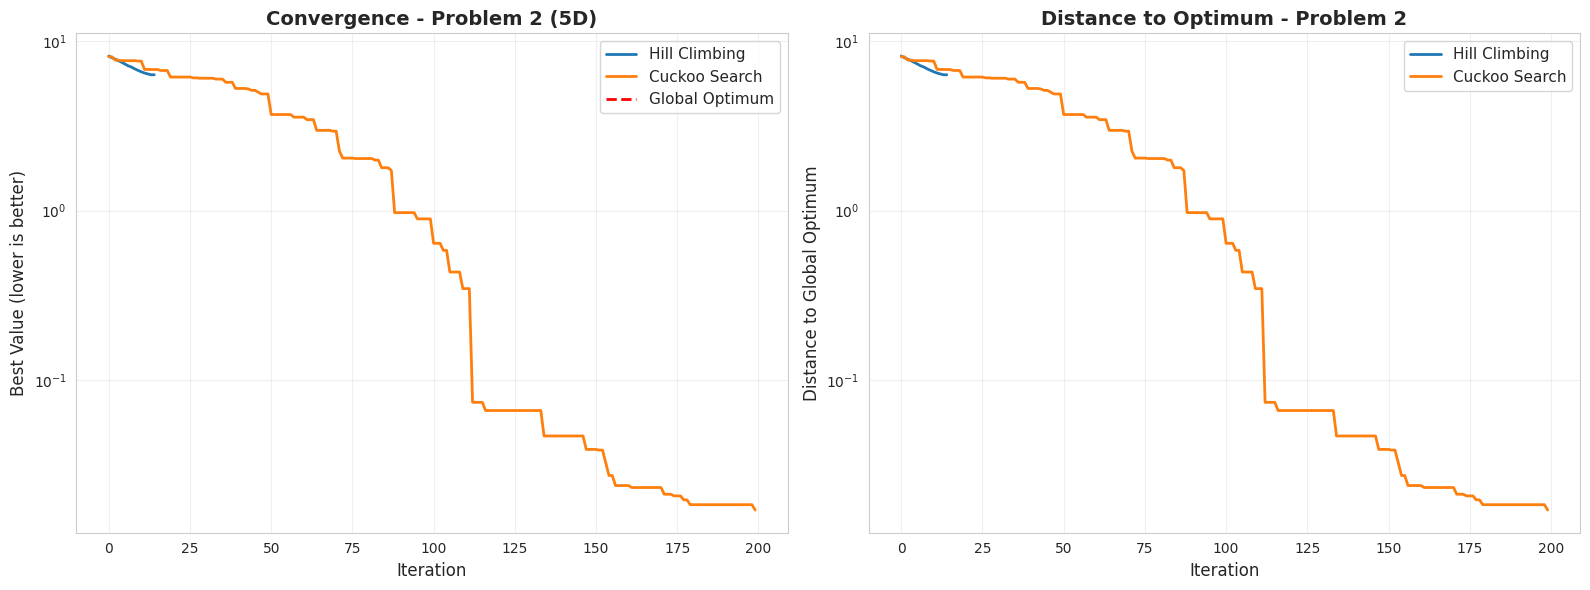

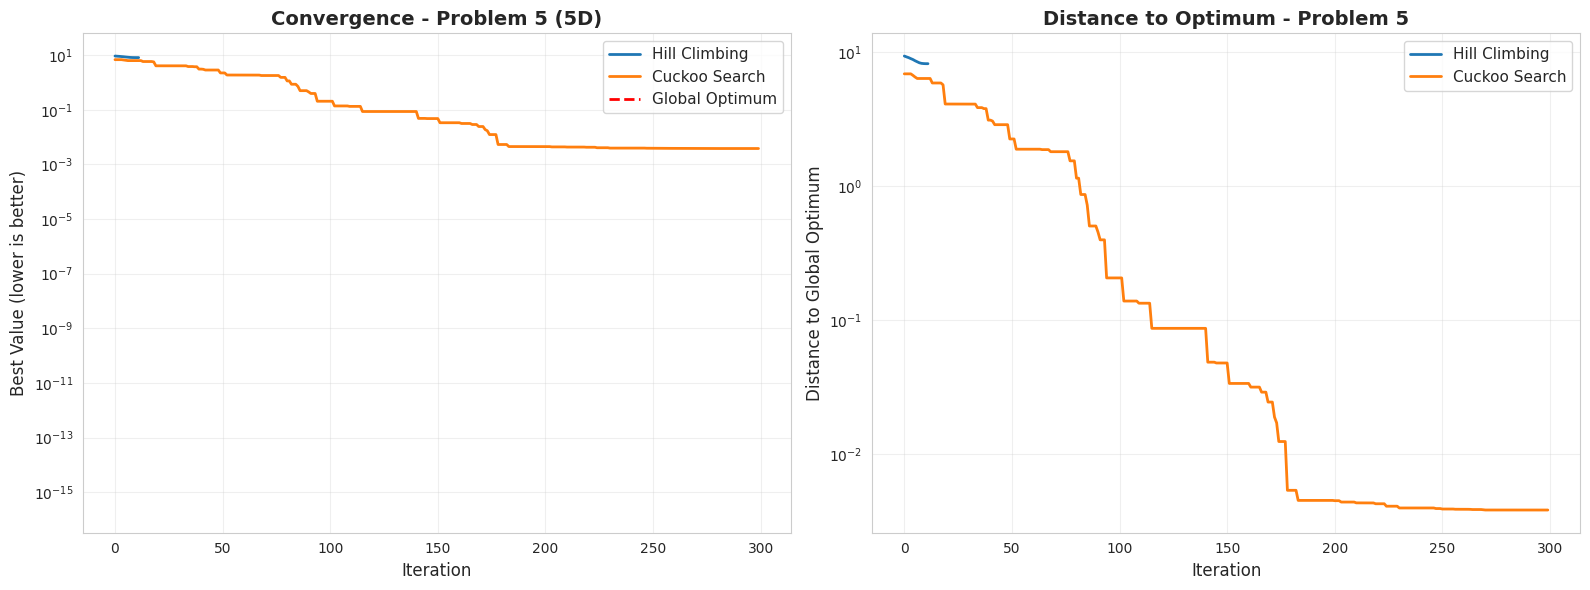

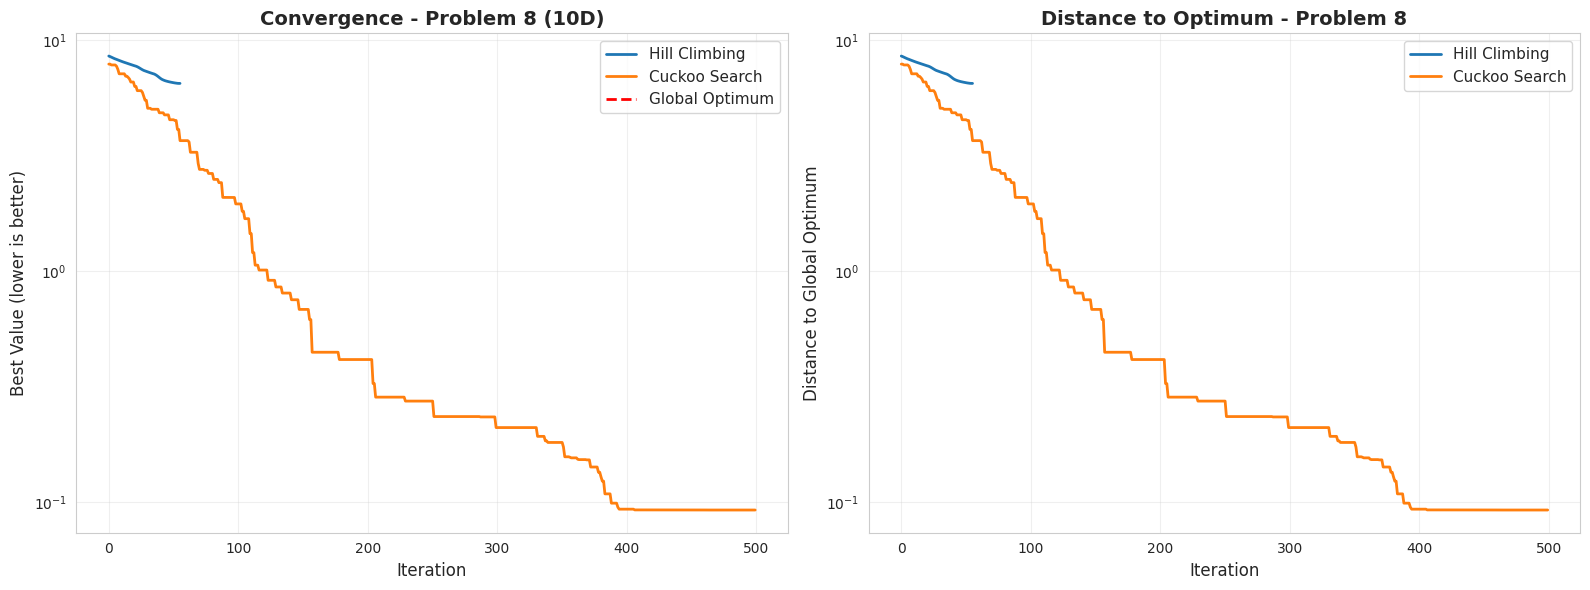

In [9]:
def plot_convergence(results_df, problem_num):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    problem_data = results_df[results_df["Problem"] == problem_num]

    if problem_data.empty:
        print(f"No data for problem {problem_num}")
        return

    ax1 = axes[0]
    for _, row in problem_data.iterrows():
        ax1.plot(row["Convergence History"], label=row["Algorithm"], linewidth=2)

    ax1.axhline(y=0.0, color="red", linestyle="--", label="Global Optimum", linewidth=2)
    ax1.set_xlabel("Iteration", fontsize=12)
    ax1.set_ylabel("Best Value (lower is better)", fontsize=12)
    ax1.set_title(
        f"Convergence - Problem {problem_num} ({problem_data.iloc[0]['Dimension']}D)",
        fontsize=14,
        fontweight="bold",
    )
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale("log")

    ax2 = axes[1]
    for _, row in problem_data.iterrows():
        distances = [abs(h) for h in row["Convergence History"]]
        ax2.plot(distances, label=row["Algorithm"], linewidth=2)

    ax2.set_xlabel("Iteration", fontsize=12)
    ax2.set_ylabel("Distance to Global Optimum", fontsize=12)
    ax2.set_title(
        f"Distance to Optimum - Problem {problem_num}", fontsize=14, fontweight="bold"
    )
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale("log")

    plt.tight_layout()
    plt.show()


for prob in [2, 5, 8]:
    if prob in all_results["Problem"].values:
        plot_convergence(all_results, prob)

### 5.2 Metric 2: Solution Quality

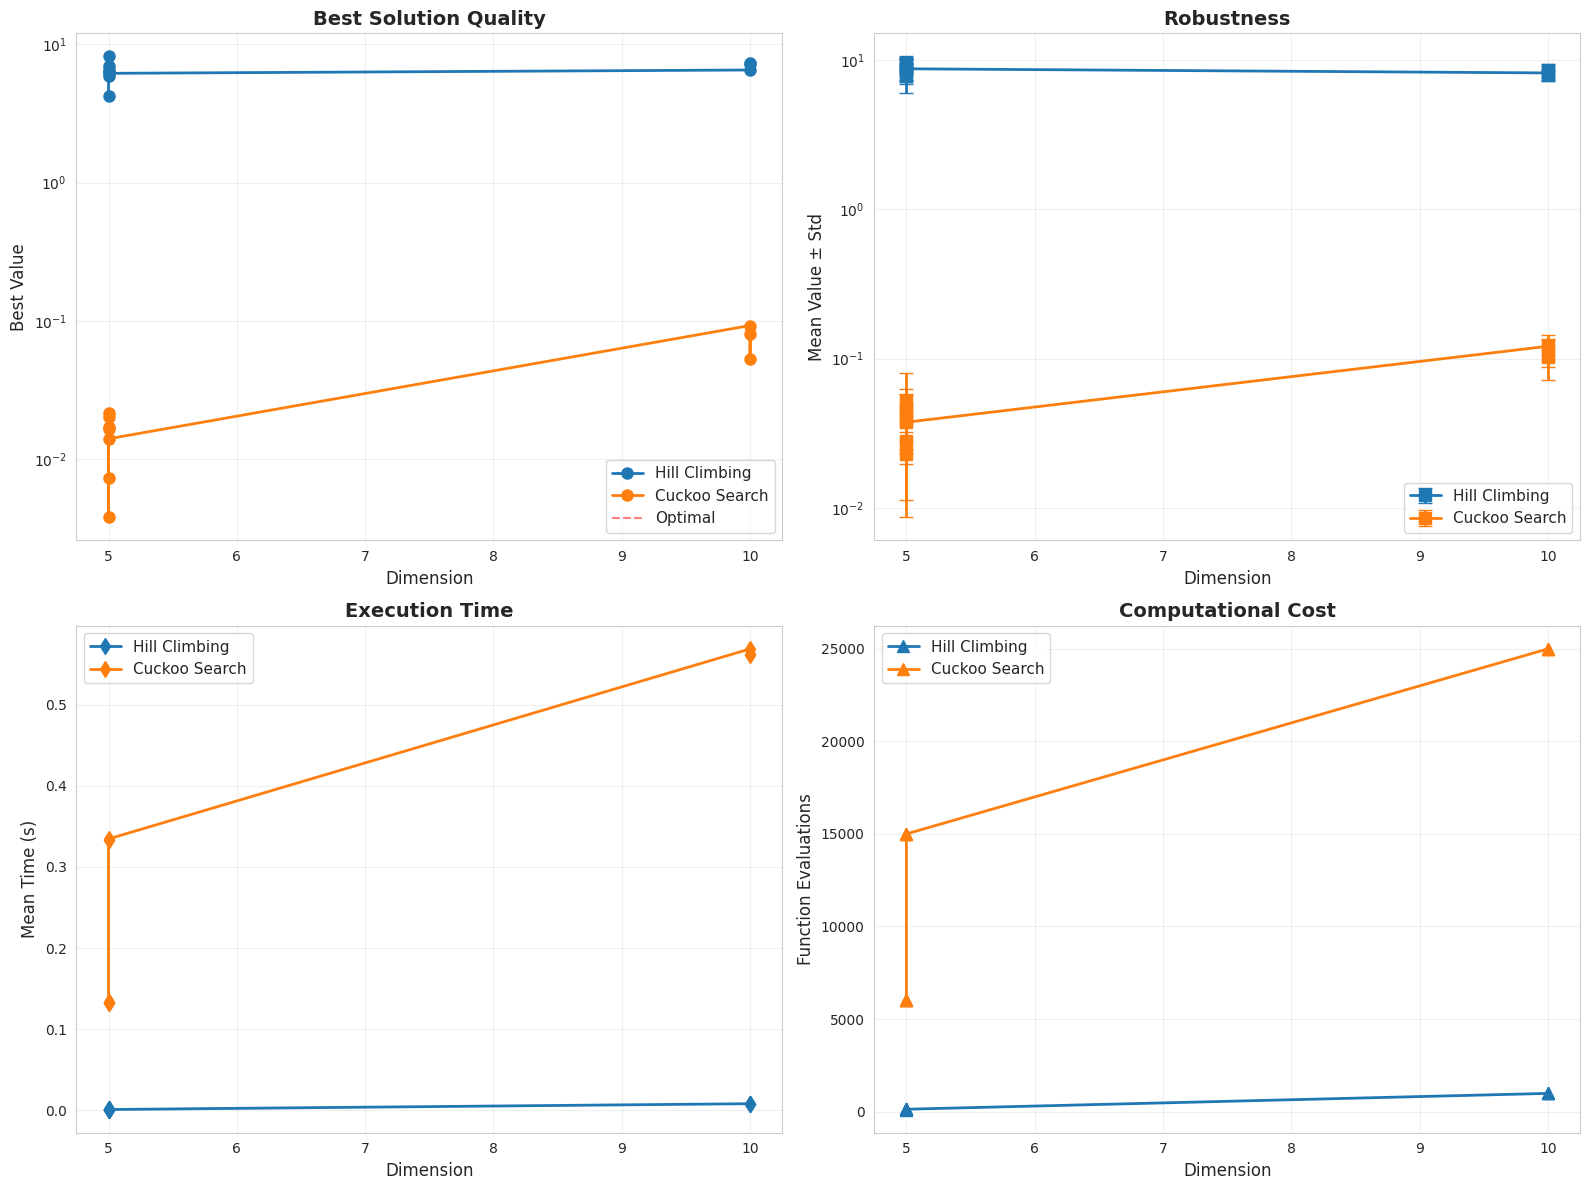

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Best Value vs Dimension
ax1 = axes[0, 0]
for algo in all_results["Algorithm"].unique():
    data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    ax1.plot(
        data["Dimension"],
        data["Best Value"],
        marker="o",
        label=algo,
        linewidth=2,
        markersize=8,
    )
ax1.axhline(y=0.0, color="red", linestyle="--", alpha=0.5, label="Optimal")
ax1.set_xlabel("Dimension", fontsize=12)
ax1.set_ylabel("Best Value", fontsize=12)
ax1.set_title("Best Solution Quality", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_yscale("log")

# Mean ± Std
ax2 = axes[0, 1]
for algo in all_results["Algorithm"].unique():
    data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    ax2.errorbar(
        data["Dimension"],
        data["Mean Value"],
        yerr=data["Std Value"],
        marker="s",
        label=algo,
        linewidth=2,
        markersize=8,
        capsize=5,
    )
ax2.set_xlabel("Dimension", fontsize=12)
ax2.set_ylabel("Mean Value ± Std", fontsize=12)
ax2.set_title("Robustness", fontsize=14, fontweight="bold")
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_yscale("log")

# Execution Time
ax3 = axes[1, 0]
for algo in all_results["Algorithm"].unique():
    data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    ax3.plot(
        data["Dimension"],
        data["Mean Time (s)"],
        marker="d",
        label=algo,
        linewidth=2,
        markersize=8,
    )
ax3.set_xlabel("Dimension", fontsize=12)
ax3.set_ylabel("Mean Time (s)", fontsize=12)
ax3.set_title("Execution Time", fontsize=14, fontweight="bold")
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Evaluations
ax4 = axes[1, 1]
for algo in all_results["Algorithm"].unique():
    data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    ax4.plot(
        data["Dimension"],
        data["Evaluations"],
        marker="^",
        label=algo,
        linewidth=2,
        markersize=8,
    )
ax4.set_xlabel("Dimension", fontsize=12)
ax4.set_ylabel("Function Evaluations", fontsize=12)
ax4.set_title("Computational Cost", fontsize=14, fontweight="bold")
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Statistical Summary

In [11]:
summary_stats = (
    all_results.groupby("Algorithm")
    .agg(
        {
            "Best Value": ["mean", "std", "min"],
            "Mean Value": ["mean", "std"],
            "Mean Time (s)": ["mean", "std"],
            "Evaluations": ["mean"],
        }
    )
    .round(6)
)

print("\n" + "=" * 100)
print("COMPREHENSIVE STATISTICAL SUMMARY")
print("=" * 100)
print(summary_stats)

# Rankings
ranking_metrics = (
    all_results.groupby("Algorithm")
    .agg(
        {
            "Best Value": "mean",
            "Mean Time (s)": "mean",
            "Std Value": "mean",
        }
    )
    .reset_index()
)

ranking_metrics["Quality Rank"] = ranking_metrics["Best Value"].rank(ascending=True)
ranking_metrics["Speed Rank"] = ranking_metrics["Mean Time (s)"].rank(ascending=True)
ranking_metrics["Robustness Rank"] = ranking_metrics["Std Value"].rank(ascending=True)
ranking_metrics["Overall Rank"] = (
    ranking_metrics["Quality Rank"]
    + ranking_metrics["Speed Rank"]
    + ranking_metrics["Robustness Rank"]
) / 3

print("\n" + "=" * 100)
print("ALGORITHM RANKINGS")
print("=" * 100)
print(
    ranking_metrics.sort_values("Overall Rank")[
        ["Algorithm", "Quality Rank", "Speed Rank", "Robustness Rank", "Overall Rank"]
    ].to_string(index=False)
)


COMPREHENSIVE STATISTICAL SUMMARY
              Best Value                     Mean Value            \
                    mean       std       min       mean       std   
Algorithm                                                           
Cuckoo Search   0.032715  0.031402  0.003821   0.060483  0.036630   
Hill Climbing   6.504127  1.046903  4.197287   8.566830  0.513258   

              Mean Time (s)           Evaluations  
                       mean       std        mean  
Algorithm                                          
Cuckoo Search      0.322618  0.188367     14400.0  
Hill Climbing      0.003154  0.003415       384.5  

ALGORITHM RANKINGS
    Algorithm  Quality Rank  Speed Rank  Robustness Rank  Overall Rank
Cuckoo Search           1.0         2.0              1.0      1.333333
Hill Climbing           2.0         1.0              2.0      1.666667


### 5.4 Radar Chart

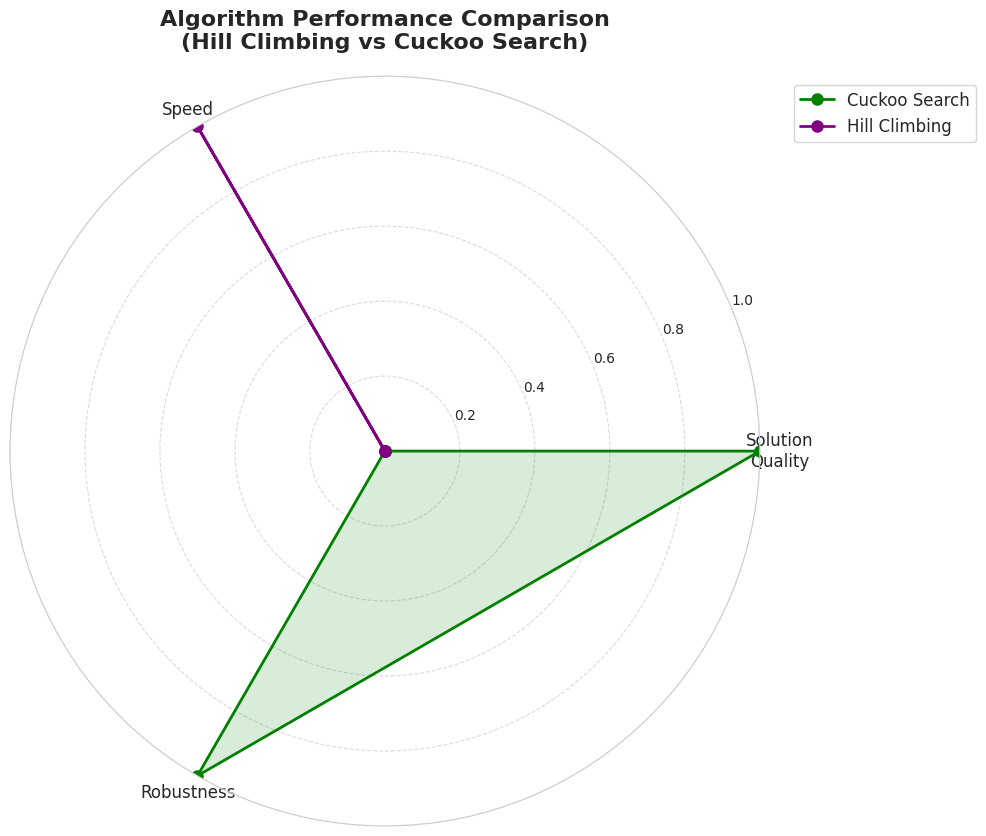

In [12]:
def normalize_metric(values, higher_is_better=True):
    min_val, max_val = values.min(), values.max()
    if max_val == min_val:
        return np.ones_like(values)
    normalized = (values - min_val) / (max_val - min_val)
    return normalized if higher_is_better else 1 - normalized


radar_data = (
    all_results.groupby("Algorithm")
    .agg(
        {
            "Best Value": "mean",
            "Mean Time (s)": "mean",
            "Std Value": "mean",
        }
    )
    .reset_index()
)

radar_data["Quality_norm"] = normalize_metric(radar_data["Best Value"].values, False)
radar_data["Speed_norm"] = normalize_metric(radar_data["Mean Time (s)"].values, False)
radar_data["Robustness_norm"] = normalize_metric(radar_data["Std Value"].values, False)

categories = ["Solution\nQuality", "Speed", "Robustness"]
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="polar"))
colors = ["green", "purple"]

for idx, row in radar_data.iterrows():
    values = [row["Quality_norm"], row["Speed_norm"], row["Robustness_norm"]]
    values += values[:1]
    ax.plot(
        angles,
        values,
        "o-",
        linewidth=2,
        label=row["Algorithm"],
        color=colors[idx],
        markersize=8,
    )
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], size=10)
ax.grid(True, linestyle="--", alpha=0.7)
ax.set_title(
    "Algorithm Performance Comparison\n(Hill Climbing vs Cuckoo Search)",
    size=16,
    fontweight="bold",
    pad=20,
)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0), fontsize=12)

plt.tight_layout()
plt.show()

## 6. Conclusions

### Kết luận từ việc so sánh trên Ackley Function:

#### 1. **Convergence Speed (Tốc độ hội tụ)**
- **Hill Climbing**: Converge nhanh ban đầu nhưng stuck ở local minima
- **Cuckoo Search**: Converge ổn định nhờ Levy flight, escape local minima tốt

#### 2. **Computational Complexity (Độ phức tạp)**
- **Hill Climbing**: Rất nhanh, O(n) neighbors per iteration
- **Cuckoo Search**: Moderate cost, balance giữa exploration và exploitation

#### 3. **Robustness (Tính bền vững)**
- **Hill Climbing**: High variance, phụ thuộc initial solution
- **Cuckoo Search**: More consistent, population-based approach

#### 4. **Scalability (Khả năng mở rộng)**
- **Hill Climbing**: Struggle với high dimensions
- **Cuckoo Search**: Better scaling với Levy flight mechanism

### Khuyến nghị:
- **Hill Climbing**: Quick local optimization, refinement
- **Cuckoo Search**: Global optimization với nhiều local minima
- **Cuckoo's advantage**: Levy flight giúp explore search space tốt hơn random walk